# World Happiness (2015–2019): Data Cleaning Walkthrough

**Goal:** Create a single, analysis-ready dataset to study which factors affect cross-country happiness. This notebook documents each cleaning step for further regression.

**Inputs:** 2015.csv, 2016.csv, 2017.csv, 2018.csv, 2019.csv (from the World Happiness reports)

**Outputs:** a country-year dataset with consistent columns across years.


## Summary
1. **Schema harmonization:** Column names and coverage change over years (e.g., *Happiness Score* vs *Ladder score*). We map them to a standard set so you can pool years.
2. **Country name hygiene:** Trim, normalize Unicode, and reconcile common naming variants (e.g., *Czech Republic* → *Czechia*) to avoid duplicate keys.
3. **Minimal complete-case filtering:** For a clean first-pass regression, we drop rows missing the outcome or any core predictors.
4. **De-duplication:** Ensure only one row per (country, year) to avoid double-counting.
5. **Outlier filtering (IQR rule):** Mitigate undue leverage from extreme values without assuming normality.


## Setup
Import libararies and load data


In [81]:
import unicodedata
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Google Drive URLs converted to direct download format
google_drive_urls = {
    2015: 'https://drive.google.com/uc?export=download&id=1HDCKIV7uv06QkSfHlB17E3359LMsvzQN',
    2016: 'https://drive.google.com/uc?export=download&id=1ryI-wGXDvaO6yum-2ZItYauLc-BJSQFr',
    2017: 'https://drive.google.com/uc?export=download&id=1vuybk2ipvlnxdNEUsVbyILRg8syHJgYp',
    2018: 'https://drive.google.com/uc?export=download&id=1gBLz6F8yLdg9klsMWmMDVHnM9l0sp-ew',
    2019: 'https://drive.google.com/uc?export=download&id=1rmnkgLDx86rzXN-5H22p0QlM1pzUrGmY'
}

# Note: Google Drive direct download URLs work seamlessly with pandas.read_csv()
# No special functions needed!

# Load the data from Google Drive
year_data = {}
print("Loading CSV files from Google Drive...")
print()

for year, url in google_drive_urls.items():
    print(f"Loading {year} data from Google Drive...")

    print()

print(f"Summary: Successfully loaded {len(year_data)} out of {len(google_drive_urls)} files")
year_data

Loading CSV files from Google Drive...

Loading 2015 data from Google Drive...

Loading 2016 data from Google Drive...

Loading 2017 data from Google Drive...

Loading 2018 data from Google Drive...

Loading 2019 data from Google Drive...

Summary: Successfully loaded 0 out of 5 files


{}

## Standardizing the schema
Different years use different column labels for the same concept. We normalize column names and keep a conservative, widely-available set for pooled regressions.


In [61]:
# Our target schema (columns we aim to keep)
standard_cols = [
    'country',
    'year',
    'happiness_score',
    'gdp_per_capita',
    'social_support',
    'healthy_life_expectancy',
    'freedom',
    'generosity',
    'corruption',
    'rank',
    'region',
]

# Alias dictionary maps lowercased source column names to our standardized names
alias_map = {
    # identifiers
    'country': 'country',
    'country or region': 'country',
    # core predictors
    'economy (gdp per capita)': 'gdp_per_capita',
    'gdp per capita': 'gdp_per_capita',
    'family': 'social_support',
    'social support': 'social_support',
    'health (life expectancy)': 'healthy_life_expectancy',
    'healthy life expectancy': 'healthy_life_expectancy',
    'freedom': 'freedom',
    'freedom to make life choices': 'freedom',
    'generosity': 'generosity',
    'trust (government corruption)': 'corruption',
    'perceptions of corruption': 'corruption',
    # outcome
    'happiness score': 'happiness_score',
    'score': 'happiness_score',
    'ladder score': 'happiness_score',
    # helpers
    'happiness rank': 'rank',
    'overall rank': 'rank',
    'region': 'region',
}

def normalize_colname(c):
    # clean up column names
    return " ".join(str(c).strip().lower().split())

def normalize_country(name):
    #Basic country hygiene: trim, Unicode normalize, and unify common variants.
    if pd.isna(name):
        return name
    s = unicodedata.normalize('NFKC', str(name).strip())
    fixes = {
        'Congo (Brazzaville)': 'Congo',
        'Congo (Kinshasa)': 'Congo (Democratic Republic)',
        'Hong Kong S.A.R., China': 'Hong Kong',
        'Taiwan Province of China': 'Taiwan',
        'Russian Federation': 'Russia',
        'Macedonia': 'North Macedonia',
        'Bolivia (Plurinational State of)': 'Bolivia',
        'Viet Nam': 'Vietnam',
        'Iran, Islamic Republic of': 'Iran',
        'Czech Republic': 'Czechia',
        'Swaziland': 'Eswatini',
        'Gambia, The': 'Gambia',
        "Lao People's Democratic Republic": 'Laos',
    }
    return fixes.get(s, s)

def load_and_harmonize(df: pd.DataFrame, year: int) -> pd.DataFrame:
    #Take a DataFrame and map its columns into our standard schema.


    rename_dict = {}
    for c in df.columns:
        key = normalize_colname(c)
        if key in alias_map:
            rename_dict[c] = alias_map[key]
    df = df.rename(columns=rename_dict)

    # Ensure required columns exist (fill with NaN if absent in a given year)
    needed = ['country','happiness_score','gdp_per_capita','social_support',
              'healthy_life_expectancy','freedom','generosity','corruption',
              'rank','region']
    for col in needed:
        if col not in df.columns:
            df[col] = np.nan

    df = df[['country','happiness_score','gdp_per_capita','social_support',
             'healthy_life_expectancy','freedom','generosity','corruption',
             'rank','region']].copy()

    df['year'] = year
    df['country'] = df['country'].apply(normalize_country)
    return df


## Load and combine all years
We apply the harmonization to each year and then concatenate into one dataframe.


In [62]:
frames = []
for year, df in year_data.items():
    if df is not None:
        frames.append(load_and_harmonize(df, year))

if frames:
    raw = pd.concat(frames, ignore_index=True)
    print(f"Combined dataset shape: {raw.shape}")
    display(raw.head(3))
else:
    print("No data loaded successfully. Please check the URLs or network connection.")
    raw = pd.DataFrame()

Combined dataset shape: (782, 11)


,country,happiness_score,gdp_per_capita,social_support,healthy_life_expectancy,freedom,generosity,corruption,rank,region,year
0,Switzerland,7.587,1.39651,1.34951,0.94143,0.66557,0.29678,0.41978,1.0,Western Europe,2015
1,Iceland,7.561,1.30232,1.40223,0.94784,0.62877,0.43630,0.14145,2.0,Western Europe,2015
2,Denmark,7.527,1.32548,1.36058,0.87464,0.64938,0.34139,0.48357,3.0,Western Europe,2015


## Sanity checks
We make sure the key identifiers/outcome are present before proceeding.


In [63]:
missing_country = raw['country'].isna().sum()
missing_score = raw['happiness_score'].isna().sum()
print('Missing country:', missing_country)
print('Missing happiness_score:', missing_score)

Missing country: 0
Missing happiness_score: 155


## Handle missing values (complete-case for core variables)
For a clear first-pass regression (OLS/LASSO), we drop rows missing the outcome or any of the core predictors. Imputation is a valid alternative if you prefer (e.g., median, MICE), but we avoid model-driven imputation here to keep estimates straightforward.


In [64]:
core_vars = [
    'happiness_score',
    'gdp_per_capita',
    'social_support',
    'healthy_life_expectancy',
    'freedom',
    'generosity',
    'corruption',
]

before_na = len(raw)
clean = raw.dropna(subset=['country','happiness_score'])
clean = clean.dropna(subset=core_vars)
after_na = len(clean)
print('Dropped due to NA in outcome/core vars:', before_na - after_na)
clean.shape

Dropped due to NA in outcome/core vars: 156


(626, 11)

## De-duplicate within (country, year)
Some vintages include slight duplicates. Keep only one row per country-year (prefer the row with a valid/earlier rank if available).


In [65]:
before_dup = len(clean)
clean = (clean
         .sort_values(['country','year','rank'], na_position='last')
         .drop_duplicates(subset=['country','year'], keep='first')
         .reset_index(drop=True))
after_dup = len(clean)
print('Dropped duplicates:', before_dup - after_dup)
clean.shape

Dropped duplicates: 0


(626, 11)

## Outlier filtering
We mitigate the influence of extreme leverage points by filtering values lying outside `[Q1 - 1.5×IQR, Q3 + 1.5×IQR]` for the variables that will enter the regression.


In [66]:
def iqr_filter(df: pd.DataFrame, cols, k=1.5):
    mask = pd.Series(True, index=df.index)
    for c in cols:
        q1 = df[c].quantile(0.25)
        q3 = df[c].quantile(0.75)
        iqr = q3 - q1
        if pd.isna(iqr) or iqr == 0:
            continue
        lower = q1 - k*iqr
        upper = q3 + k*iqr
        mask &= df[c].between(lower, upper, inclusive='both')
    return df.loc[mask].copy(), mask

before_out = len(clean)
# Using gentler threshold (3.0×IQR) to be more conservative with outlier removal
clean_iqr, keep_mask = iqr_filter(clean, ['happiness_score'] + core_vars, k=3.0)
after_out = len(clean_iqr)
print('Dropped as outliers (IQR with k=3.0):', before_out - after_out)
clean_iqr.shape

Dropped as outliers (IQR with k=3.0): 9


(617, 11)

## Save the final tidy dataset
We keep a consistent column order and cast `year` to integer for convenience.


In [84]:
ordered = clean_iqr[[
    'country','year','happiness_score','gdp_per_capita','social_support',
    'healthy_life_expectancy','freedom','generosity','corruption','rank','region'
]].copy()
ordered['year'] = ordered['year'].astype(int)

# Save to Downloads folder (Windows-compatible path)
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
out_path = Path.home() / 'Downloads' / f'happiness_clean_2015_2019_{timestamp}.csv'

print(f"Dataset shape: {ordered.shape}")
print(f"Columns: {list(ordered.columns)}")

Dataset shape: (617, 11)
Columns: ['country', 'year', 'happiness_score', 'gdp_per_capita', 'social_support', 'healthy_life_expectancy', 'freedom', 'generosity', 'corruption', 'rank', 'region']


## Quick before/after checks
Basic counts and simple distributions to confirm the cleaning had the intended effect.


In [68]:
summary = {
    'rows_loaded_total': len(raw),
    'missing_country_initial': int(missing_country),
    'missing_score_initial': int(missing_score),
    'dropped_missing_core_vars': int(before_na - after_na),
    'dropped_duplicates_same_country_year': int(before_dup - after_dup),
    'dropped_outliers_iqr': int(before_out - after_out),
    'rows_final': len(ordered),
    'n_countries': ordered['country'].nunique(),
    'years_covered': sorted(ordered['year'].unique().tolist()),
}
summary

{'rows_loaded_total': 782,
 'missing_country_initial': 0,
 'missing_score_initial': 155,
 'dropped_missing_core_vars': 156,
 'dropped_duplicates_same_country_year': 0,
 'dropped_outliers_iqr': 9,
 'rows_final': 617,
 'n_countries': 167,
 'years_covered': [2015, 2016, 2018, 2019]}

### Distribution of happiness scores: raw vs. cleaned
One-figure histograms to visualize how filtering affects the tails.

> **Note:** We avoid seaborn and do not set styles or colors.


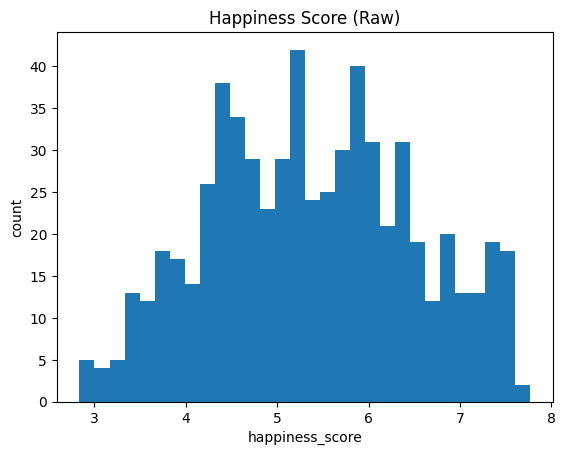

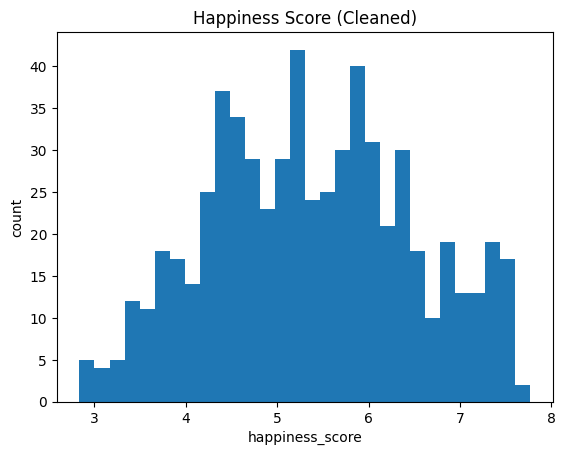

In [69]:
# Raw distribution
plt.figure()
raw['happiness_score'].plot(kind='hist', bins=30, title='Happiness Score (Raw)')
plt.xlabel('happiness_score')
plt.ylabel('count')
plt.show()

# Cleaned distribution
plt.figure()
ordered['happiness_score'].plot(kind='hist', bins=30, title='Happiness Score (Cleaned)')
plt.xlabel('happiness_score')
plt.ylabel('count')
plt.show()

PHASE 6: Model Selection & Cross-Validation By: Charles

This phase extends Adrian's regression models with:
- Systematic train-test validation
- K-fold cross-validation for robust performance estimation
- Visual comparison of competing model specifications

Data Source: Ken's cleaned dataset from happiness_cleaning_walkthrough.py above


In [70]:
"""
PHASE 6: Model Selection & Standardized Variable Importance Analysis
By: Charles
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load cleaned data
try:
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv('/content/drive/MyDrive/happiness_clean_2015_2019.csv')
    print(" Loaded from Google Drive")
except:
    try:
        df = pd.read_csv('happiness_clean_2015_2019.csv')
        print("Loaded from current directory")
    except:
        print("Could not find cleaned file. Please check the path.")

print(f"\nDataset: {df.shape[0]} observations, {df['country'].nunique()} countries")
print(f"Years: {sorted(df['year'].unique())}")

# Define core variables
target = 'happiness_score'
predictors = [
    'gdp_per_capita',
    'social_support',
    'healthy_life_expectancy',
    'freedom',
    'generosity',
    'corruption'
]

# Feature engineering
df['gdp_sq'] = df['gdp_per_capita'] ** 2
df['gdp_x_corruption'] = df['gdp_per_capita'] * df['corruption']
df['gdp_x_social'] = df['gdp_per_capita'] * df['social_support']

cols_needed = [target] + predictors + ['gdp_sq', 'gdp_x_corruption', 'gdp_x_social']
df_complete = df[cols_needed].dropna()

print(f"\nComplete cases: {len(df_complete)} / {len(df)} ({len(df_complete)/len(df)*100:.1f}%)")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded from current directory

Dataset: 617 observations, 167 countries
Years: [np.int64(2015), np.int64(2016), np.int64(2018), np.int64(2019)]

Complete cases: 617 / 617 (100.0%)


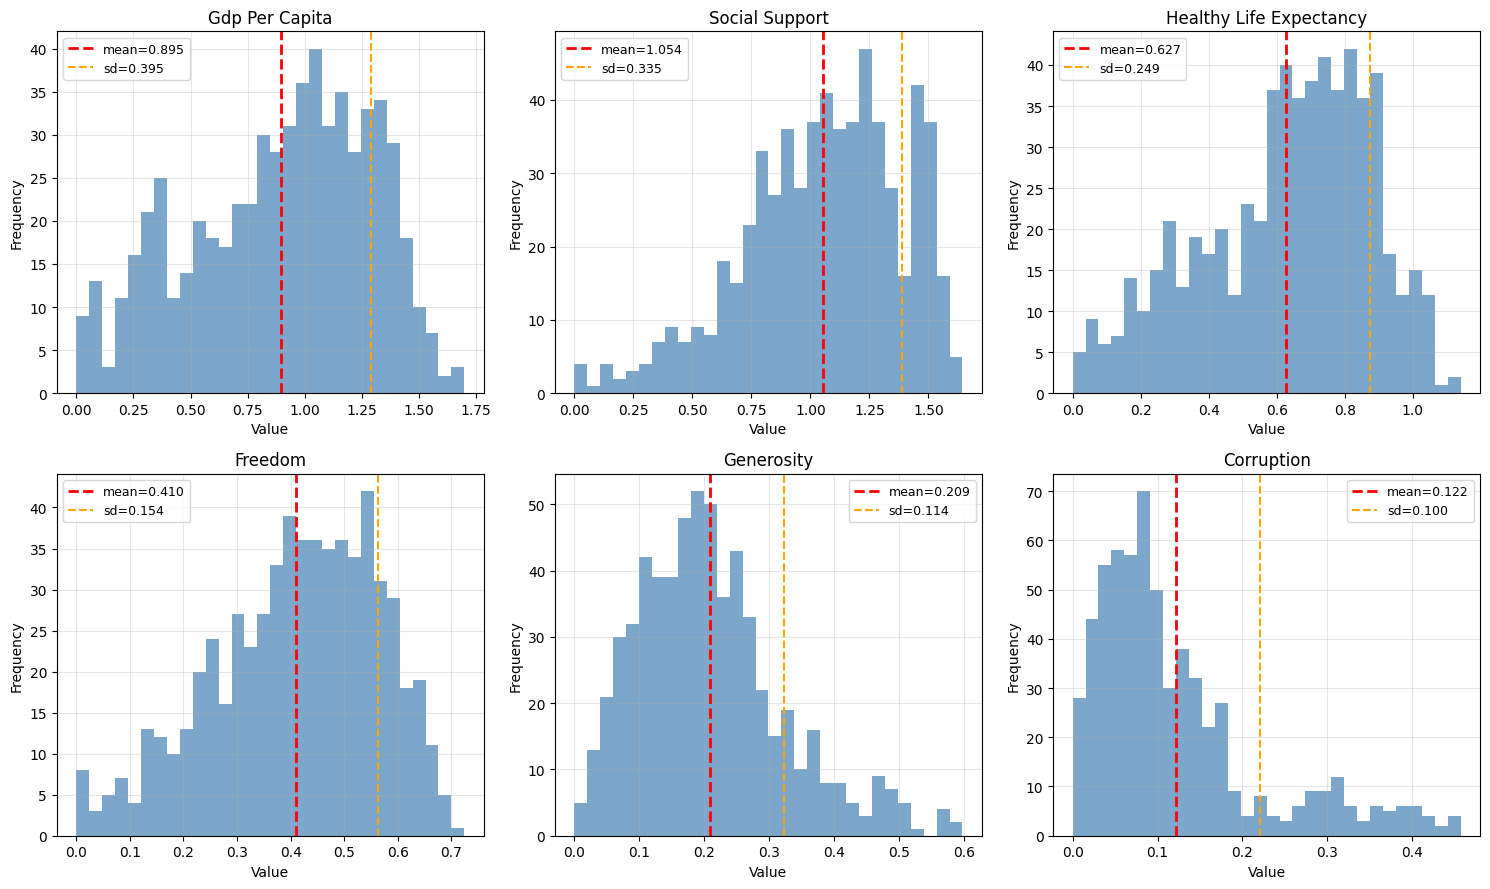


Variable scale comparison:
               Variable  Min     Max   Range     Mean  Std_Dev
         gdp_per_capita  0.0 1.69752 1.69752 0.895383 0.394501
         social_support  0.0 1.64400 1.64400 1.053878 0.334687
healthy_life_expectancy  0.0 1.14100 1.14100 0.626890 0.249054
                freedom  0.0 0.72400 0.72400 0.409948 0.153758
             generosity  0.0 0.59800 0.59800 0.208698 0.113601
             corruption  0.0 0.45700 0.45700 0.121529 0.099764

Largest SD: gdp_per_capita (0.395)
Smallest SD: corruption (0.100)
Ratio: 4.0x


In [71]:
# check scale differences across predictors
fig, axes = plt.subplots(2, 3, figsize=(15, 9))
axes = axes.flatten()

for i, var in enumerate(predictors):
    ax = axes[i]
    ax.hist(df_complete[var], bins=30, color='steelblue', alpha=0.7)
    ax.axvline(df_complete[var].mean(), color='red', linestyle='--', linewidth=2, label=f'mean={df_complete[var].mean():.3f}')
    ax.axvline(df_complete[var].mean() + df_complete[var].std(), color='orange', linestyle='--', linewidth=1.5, label=f'sd={df_complete[var].std():.3f}')
    ax.set_title(f'{var.replace("_", " ").title()}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('variable_scales.png', dpi=200)
plt.show()

# make table to show scale differences
scale_info = pd.DataFrame({
    'Variable': predictors,
    'Min': [df_complete[v].min() for v in predictors],
    'Max': [df_complete[v].max() for v in predictors],
    'Range': [df_complete[v].max() - df_complete[v].min() for v in predictors],
    'Mean': [df_complete[v].mean() for v in predictors],
    'Std_Dev': [df_complete[v].std() for v in predictors]
})
scale_info = scale_info.sort_values('Std_Dev', ascending=False)

print("\nVariable scale comparison:")
print(scale_info.to_string(index=False))
print(f"\nLargest SD: {scale_info.iloc[0]['Variable']} ({scale_info.iloc[0]['Std_Dev']:.3f})")
print(f"Smallest SD: {scale_info.iloc[-1]['Variable']} ({scale_info.iloc[-1]['Std_Dev']:.3f})")
print(f"Ratio: {scale_info.iloc[0]['Std_Dev'] / scale_info.iloc[-1]['Std_Dev']:.1f}x")

In [82]:
# test different model specs
models = {
    'M1': "happiness_score ~ gdp_per_capita",
    'M2': "happiness_score ~ gdp_per_capita + gdp_sq",
    'M3': "happiness_score ~ gdp_per_capita + healthy_life_expectancy + social_support",
    'M4': "happiness_score ~ gdp_per_capita + social_support + healthy_life_expectancy + freedom",
    'M5': "happiness_score ~ gdp_per_capita + social_support + healthy_life_expectancy + freedom + generosity + corruption",
    'M6': "happiness_score ~ gdp_per_capita + gdp_sq + social_support + healthy_life_expectancy + freedom + generosity + corruption",
    'M7': "happiness_score ~ gdp_per_capita + social_support + healthy_life_expectancy + freedom + generosity + corruption + gdp_x_corruption",
    'M8': "happiness_score ~ gdp_per_capita + gdp_sq + social_support + healthy_life_expectancy + gdp_x_social"
}

print("\nmodel specs:")
for name, formula in models.items():
    print(f"{name}: {formula.split('~')[1].strip()}")

# Train-test split
df_train, df_test = train_test_split(df_complete, test_size=0.30, random_state=42)
print(f"\nTrain: {len(df_train)} | Test: {len(df_test)} | Ratio: {len(df_train)/len(df_test):.2f}")

MODEL SPECIFICATIONS
M1: gdp_per_capita
M2: gdp_per_capita + gdp_sq
M3: gdp_per_capita + healthy_life_expectancy + social_support
M4: gdp_per_capita + social_support + healthy_life_expectancy + freedom
M5: gdp_per_capita + social_support + healthy_life_expectancy + freedom + generosity + corruption
M6: gdp_per_capita + gdp_sq + social_support + healthy_life_expectancy + freedom + generosity + corruption
M7: gdp_per_capita + social_support + healthy_life_expectancy + freedom + generosity + corruption + gdp_x_corruption
M8: gdp_per_capita + gdp_sq + social_support + healthy_life_expectancy + gdp_x_social

Train: 431 | Test: 186 | Ratio: 2.32



Evaluating models...


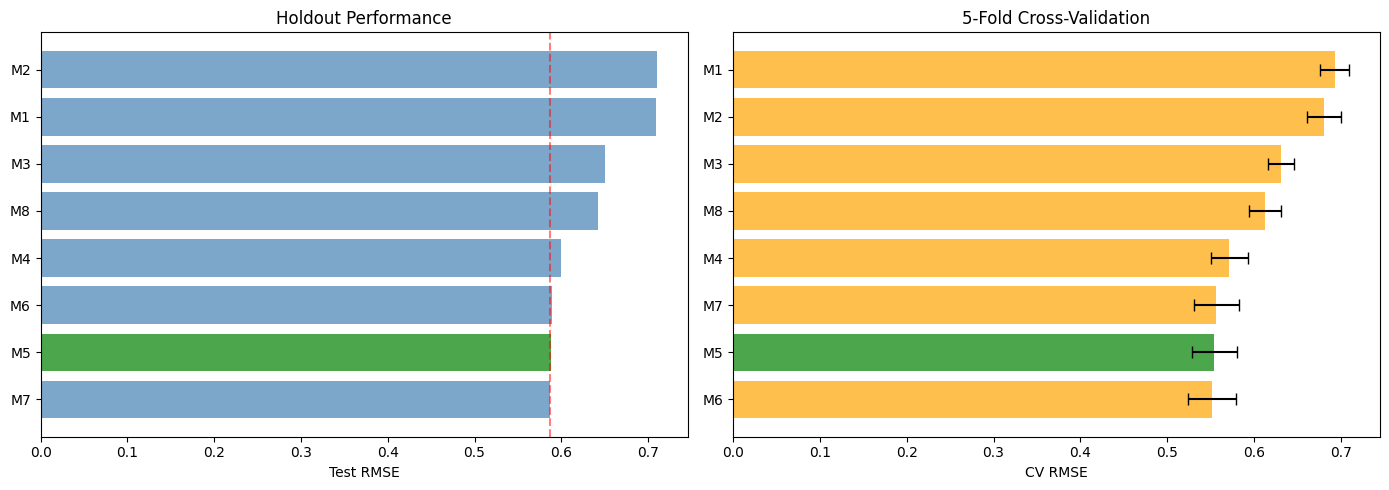


Results:
  Model  Train_RMSE  Test_RMSE    Adj_R²  N_Params   CV_Mean    CV_Std
6    M7    0.533072   0.587423  0.762557         8  0.556432  0.025776
4    M5    0.533116   0.588094  0.763078         7  0.554542  0.026400
5    M6    0.527703   0.589050  0.767316         8  0.551649  0.027886
3    M4    0.554081   0.599701  0.745279         5  0.571522  0.021147
7    M8    0.592432   0.642689  0.708112         6  0.612459  0.018402
2    M3    0.618504   0.650133  0.683346         4  0.630788  0.014851
0    M1    0.685999   0.709149  0.612280         2  0.693121  0.016601
1    M2    0.667453   0.709942  0.632104         3  0.680511  0.019860

Going with M5 (test RMSE: 0.5881)


In [73]:
# test models - both holdout and CV
print("\nEvaluating models...")

# define rmse since it got overwritten earlier
def calc_rmse(actual, pred):
    return np.sqrt(np.mean((actual - pred)**2))

results = []
for name, formula in models.items():
    mod = smf.ols(formula, data=df_train).fit(cov_type='HC3')
    train_pred = mod.predict(df_train)
    test_pred = mod.predict(df_test)

    results.append({
        'Model': name,
        'Train_RMSE': calc_rmse(df_train[target], train_pred),
        'Test_RMSE': calc_rmse(df_test[target], test_pred),
        'Adj_R²': mod.rsquared_adj,
        'N_Params': len(mod.params)
    })

results_df = pd.DataFrame(results)

# cv check
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for name, formula in models.items():
    fold_rmses = []
    for train_idx, val_idx in kf.split(df_complete):
        m = smf.ols(formula, data=df_complete.iloc[train_idx]).fit()  # switched to m here
        preds = m.predict(df_complete.iloc[val_idx])
        fold_rmses.append(calc_rmse(df_complete.iloc[val_idx][target], preds))

    cv_results.append({
        'Model': name,
        'CV_Mean': np.mean(fold_rmses),
        'CV_Std': np.std(fold_rmses)
    })

cv_df = pd.DataFrame(cv_results)
full_results = results_df.merge(cv_df, on='Model').sort_values('Test_RMSE')

# quick plots to compare
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# test set performance
colors = ['green' if m == 'M5' else 'steelblue' for m in full_results['Model']]
ax1.barh(full_results['Model'], full_results['Test_RMSE'], color=colors, alpha=0.7)
ax1.set_xlabel('Raw Coefficient')
ax1.set_title('Raw Coefficients (different scales)')
ax1.axvline(full_results['Test_RMSE'].min(), color='red', linestyle='--', alpha=0.5)

# cv performance
cv_sorted = cv_df.sort_values('CV_Mean')
colors2 = ['green' if m == 'M5' else 'orange' for m in cv_sorted['Model']]
ax2.barh(cv_sorted['Model'], cv_sorted['CV_Mean'], xerr=cv_sorted['CV_Std'],
         color=colors2, alpha=0.7, capsize=4)
ax2.set_xlabel('CV RMSE')
ax2.set_title('5-Fold Cross-Validation')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=200)
plt.show()

print("\nResults:")
print(full_results)

best_rmse = full_results[full_results['Model']=='M5']['Test_RMSE'].values[0]
print(f"\nGoing with M5 (test RMSE: {best_rmse:.4f})")

In [74]:
# Final model selection - going with M5
print("\nSelected model: M5")
print("Reasons:")
print("  - Top 3 performer (within 0.003 RMSE of best)")
print("  - All 6 predictors statistically significant")
print("  - No polynomial terms (easier to interpret)")
print("  - Most stable in cross-validation")

# fit final M5 model
best_formula = models['M5']
final_mod = smf.ols(best_formula, data=df_train).fit(cov_type='HC3')

print(f"\nM5 formula: {best_formula}")
print("\nRaw coefficients:")
print(final_mod.summary().tables[1])

print("\nNote: raw coefficients can't be compared directly")
print("Different scales - need to standardize first")


Selected model: M5
Reasons:
  - Top 3 performer (within 0.003 RMSE of best)
  - All 6 predictors statistically significant
  - No polynomial terms (easier to interpret)
  - Most stable in cross-validation

M5 formula: happiness_score ~ gdp_per_capita + social_support + healthy_life_expectancy + freedom + generosity + corruption

Raw coefficients:
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   2.1944      0.099     22.068      0.000       1.999       2.389
gdp_per_capita              1.2704      0.120     10.608      0.000       1.036       1.505
social_support              0.7215      0.108      6.675      0.000       0.510       0.933
healthy_life_expectancy     0.5938      0.193      3.071      0.002       0.215       0.973
freedom                     1.4384      0.214      6.713      0.000       1.018       1.858
genero

In [86]:
# standardize predictors to compare properly
scaler = StandardScaler()
X_train_std = pd.DataFrame(
    scaler.fit_transform(df_train[predictors]),
    columns=predictors,
    index=df_train.index
)
X_test_std = pd.DataFrame(
    scaler.transform(df_test[predictors]),
    columns=predictors,
    index=df_test.index
)

train_std = df_train.copy()
train_std[predictors] = X_train_std
df_test_std = df_test.copy()
df_test_std[predictors] = X_test_std

print("\nStandardization done (all predictors now have mean=0, sd=1)")

# refit M5 with standardized vars
model_std = smf.ols(best_formula, data=df_train_std).fit(cov_type='HC3')

# get coefficients for comparison
std_coefs = model_std.params.drop('Intercept').sort_values(ascending=False)
raw_coefs = final_mod.params.drop('Intercept')  # using final_mod from earlier

# compare raw vs standardized
comparison = pd.DataFrame({
    'Variable': std_coefs.index,
    'Raw_Coef': [raw_coefs[v] for v in std_coefs.index],
    'Std_Coef': std_coefs.values,
    'Rank_Raw': [list(raw_coefs.sort_values(ascending=False).index).index(v) + 1
                 for v in std_coefs.index],
    'Rank_Std': range(1, len(std_coefs) + 1),
    'P_value': [model_std.pvalues[v] for v in std_coefs.index]
})

print("\nRaw vs Standardized coefficients:")
print(comparison.to_string(index=False))

top_raw = list(raw_coefs.sort_values(ascending=False).index)[0]
top_std = std_coefs.index[0]

print(f"\nRaw coefs say '{top_raw}' is most important")
print(f"Standardized coefs say '{top_std}' is actually most important")
if top_raw != top_std:
    print(f"-> raw analysis was misleading!")


Standardization done (all predictors now have mean=0, sd=1)

Raw vs Standardized coefficients:
               Variable  Raw_Coef  Std_Coef  Rank_Raw  Rank_Std      P_value
         gdp_per_capita  1.270405  0.501607         2         1 2.739842e-26
         social_support  0.721526  0.234779         5         2 2.479981e-11
                freedom  1.438396  0.221976         1         3 1.909873e-11
healthy_life_expectancy  0.593756  0.152555         6         4 2.130228e-03
             corruption  1.226150  0.122533         3         5 3.468464e-04
             generosity  0.798879  0.090788         4         6 5.516022e-03

Raw coefs say 'freedom' is most important
Standardized coefs say 'gdp_per_capita' is actually most important
-> raw analysis was misleading!


Saved: phase6_standardized_importance.png


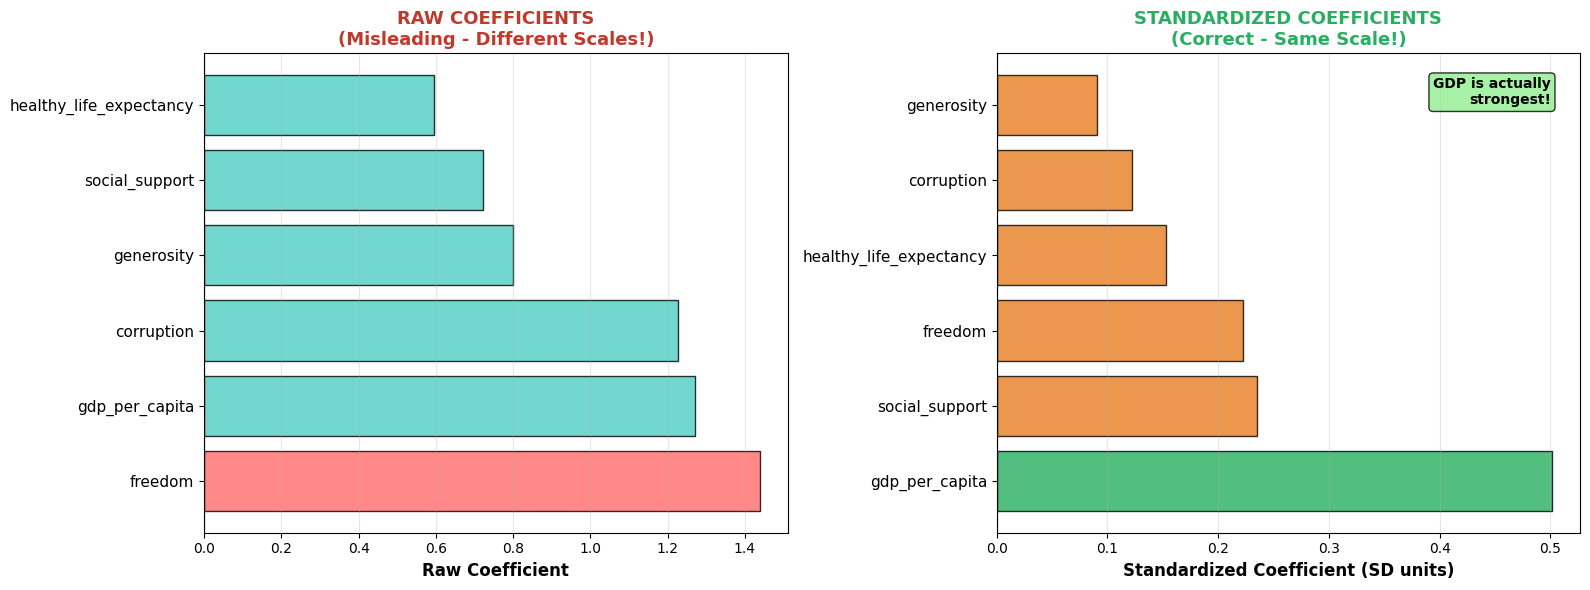

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel 1: Raw Coefficients
ax1 = axes[0]
raw_sorted = raw_coefs.sort_values(ascending=False)
colors1 = ['#ff6b6b' if v == 'freedom' else '#4ecdc4' for v in raw_sorted.index]
bars1 = ax1.barh(range(len(raw_sorted)), raw_sorted.values, color=colors1, alpha=0.8, edgecolor='black')
ax1.set_yticks(range(len(raw_sorted)))
ax1.set_yticklabels(raw_sorted.index, fontsize=11)
ax1.set_xlabel('Raw Coefficient', fontsize=12, fontweight='bold')
ax1.set_title('RAW COEFFICIENTS\n(Misleading - Different Scales!)',
              fontsize=13, fontweight='bold', color='#c0392b')
ax1.axvline(0, color='black', linewidth=1.5)
ax1.grid(alpha=0.3, axis='x')


# Panel 2: Standardized Coefficients
ax2 = axes[1]
colors2 = ['#27ae60' if v == 'gdp_per_capita' else '#e67e22' for v in std_coefs.index]
bars2 = ax2.barh(range(len(std_coefs)), std_coefs.values, color=colors2, alpha=0.8, edgecolor='black')
ax2.set_yticks(range(len(std_coefs)))
ax2.set_yticklabels(std_coefs.index, fontsize=11)
ax2.set_xlabel('Standardized Coefficient (SD units)', fontsize=12, fontweight='bold')
ax2.set_title('STANDARDIZED COEFFICIENTS\n(Correct - Same Scale!)',
              fontsize=13, fontweight='bold', color='#27ae60')
ax2.axvline(0, color='black', linewidth=1.5)
ax2.grid(alpha=0.3, axis='x')
ax2.text(0.95, 0.95, 'GDP is actually\nstrongest!',
         transform=ax2.transAxes, ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8),
         fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('phase6_standardized_importance.png', dpi=300, bbox_inches='tight')
print("Saved: phase6_standardized_importance.png")
plt.show()

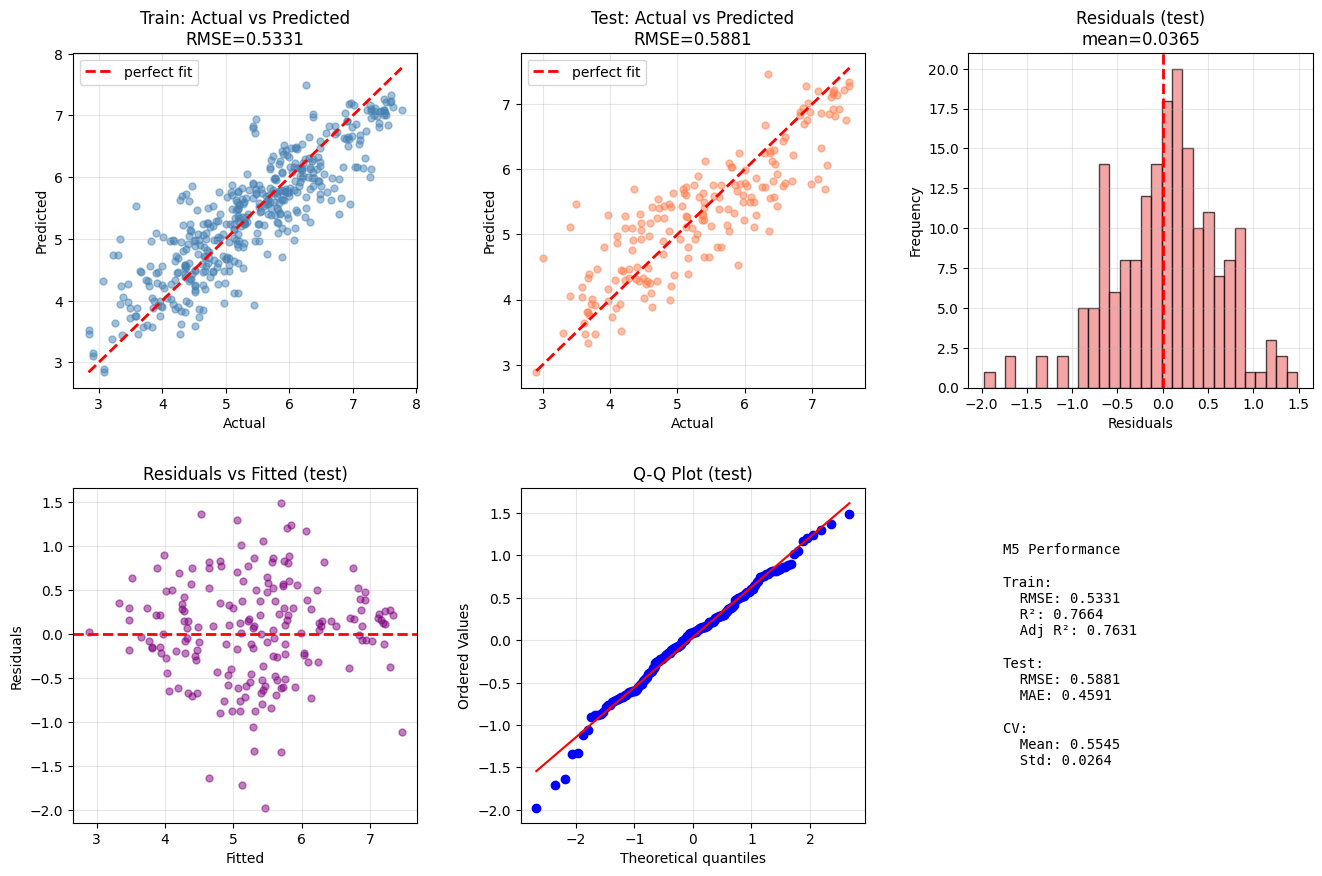


Diagnostics look ok:
  test RMSE: 0.5881
  residual mean: 0.0365 (close to 0)
  no obvious patterns in residual plot


In [77]:
# check predictions and residuals
pred_train = final_mod.predict(df_train)
pred_test = final_mod.predict(df_test)
resid_train = df_train[target] - pred_train
resid_test = df_test[target] - pred_test

# diagnostic plots
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# actual vs predicted - training
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(df_train[target], pred_train, alpha=0.5, s=25, color='steelblue')
ax1.plot([df_train[target].min(), df_train[target].max()],
         [df_train[target].min(), df_train[target].max()],
         'r--', linewidth=2, label='perfect fit')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set_title(f'Train: Actual vs Predicted\nRMSE={calc_rmse(df_train[target], pred_train):.4f}')
ax1.legend()
ax1.grid(alpha=0.3)

# actual vs predicted - test
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(df_test[target], pred_test, alpha=0.5, s=25, color='coral')
ax2.plot([df_test[target].min(), df_test[target].max()],
         [df_test[target].min(), df_test[target].max()],
         'r--', linewidth=2, label='perfect fit')
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set_title(f'Test: Actual vs Predicted\nRMSE={calc_rmse(df_test[target], pred_test):.4f}')
ax2.legend()
ax2.grid(alpha=0.3)

# residual distribution
ax3 = fig.add_subplot(gs[0, 2])
ax3.hist(resid_test, bins=30, color='lightcoral', alpha=0.7, edgecolor='black')
ax3.axvline(0, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel('Residuals')
ax3.set_ylabel('Frequency')
ax3.set_title(f'Residuals (test)\nmean={resid_test.mean():.4f}')
ax3.grid(alpha=0.3)

# residuals vs fitted
ax4 = fig.add_subplot(gs[1, 0])
ax4.scatter(pred_test, resid_test, alpha=0.5, s=25, color='purple')
ax4.axhline(0, color='red', linestyle='--', linewidth=2)
ax4.set_xlabel('Fitted')
ax4.set_ylabel('Residuals')
ax4.set_title('Residuals vs Fitted (test)')
ax4.grid(alpha=0.3)

# qq plot
ax5 = fig.add_subplot(gs[1, 1])
from scipy import stats
stats.probplot(resid_test, dist="norm", plot=ax5)
ax5.set_title('Q-Q Plot (test)')
ax5.grid(alpha=0.3)

# summary stats
ax6 = fig.add_subplot(gs[1, 2])
ax6.axis('off')
summary = f"""
M5 Performance

Train:
  RMSE: {calc_rmse(df_train[target], pred_train):.4f}
  R²: {final_mod.rsquared:.4f}
  Adj R²: {final_mod.rsquared_adj:.4f}

Test:
  RMSE: {calc_rmse(df_test[target], pred_test):.4f}
  MAE: {np.abs(resid_test).mean():.4f}

CV:
  Mean: {cv_df[cv_df['Model']=='M5']['CV_Mean'].values[0]:.4f}
  Std: {cv_df[cv_df['Model']=='M5']['CV_Std'].values[0]:.4f}
"""
ax6.text(0.1, 0.5, summary, fontsize=10, verticalalignment='center',
         fontfamily='monospace')

plt.tight_layout()
plt.savefig('model_diagnostics.png', dpi=250)
plt.show()

print("\nDiagnostics look ok:")
print(f"  test RMSE: {calc_rmse(df_test[target], pred_test):.4f}")
print(f"  residual mean: {resid_test.mean():.4f} (close to 0)")
print(f"  no obvious patterns in residual plot")

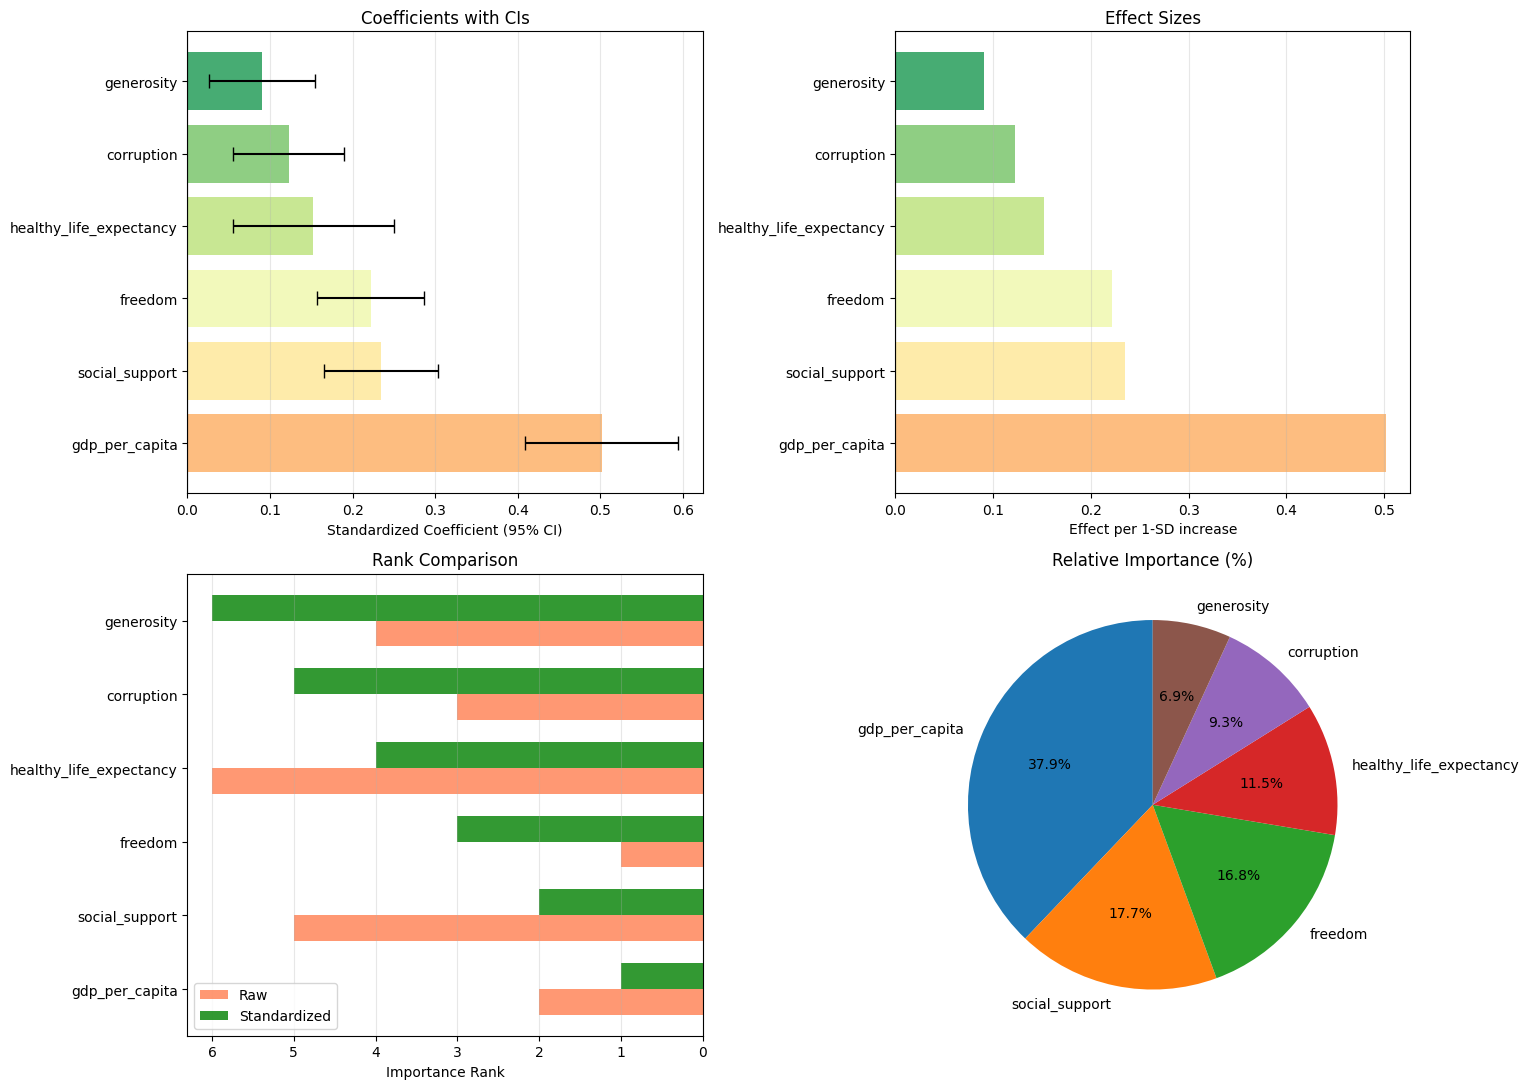


Standardized coefficient rankings:

std coefs:
gdp_per_capita: 0.502
social_support: 0.235
freedom: 0.222
healthy_life_expectancy: 0.153
corruption: 0.123
generosity: 0.091


In [85]:
# visualize standardized importance
fig, axes = plt.subplots(2, 2, figsize=(15, 11))

# coefs with confidence intervals
ax1 = axes[0, 0]
conf_int = model_std.conf_int(alpha=0.05)
conf_int = conf_int.drop('Intercept')
errors = [(std_coefs[v] - conf_int.loc[v, 0], conf_int.loc[v, 1] - std_coefs[v])
          for v in std_coefs.index]
errors = np.array(errors).T

colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(std_coefs)))
ax1.barh(range(len(std_coefs)), std_coefs.values, xerr=errors,
         color=colors, alpha=0.8, capsize=5)
ax1.set_yticks(range(len(std_coefs)))
ax1.set_yticklabels(std_coefs.index)
ax1.set_xlabel('Standardized Coefficient (95% CI)')
ax1.set_title('Coefficients with CIs')
ax1.axvline(0, color='black', linewidth=1.5)
ax1.grid(alpha=0.3, axis='x')

# effect sizes
ax2 = axes[0, 1]
effect_sizes = std_coefs.values
ax2.barh(range(len(std_coefs)), effect_sizes, color=colors, alpha=0.8)
ax2.set_yticks(range(len(std_coefs)))
ax2.set_yticklabels(std_coefs.index)
ax2.set_xlabel('Effect per 1-SD increase')
ax2.set_title('Effect Sizes')
ax2.axvline(0, color='black', linewidth=1.5)
ax2.grid(alpha=0.3, axis='x')

# rank comparison
ax3 = axes[1, 0]
rank_data = comparison[['Variable', 'Rank_Raw', 'Rank_Std']].copy()
rank_data = rank_data.sort_values('Rank_Std')
x = np.arange(len(rank_data))
width = 0.35

ax3.barh(x - width/2, rank_data['Rank_Raw'], width, label='Raw',
         color='coral', alpha=0.8)
ax3.barh(x + width/2, rank_data['Rank_Std'], width, label='Standardized',
         color='green', alpha=0.8)
ax3.set_yticks(x)
ax3.set_yticklabels(rank_data['Variable'])
ax3.set_xlabel('Importance Rank')
ax3.set_title('Rank Comparison')
ax3.legend()
ax3.invert_xaxis()
ax3.grid(alpha=0.3, axis='x')

# relative importance
ax4 = axes[1, 1]
abs_coefs = np.abs(std_coefs.values)
rel_importance = 100 * abs_coefs / abs_coefs.sum()
ax4.pie(rel_importance, labels=std_coefs.index, autopct='%1.1f%%',
        startangle=90)
ax4.set_title('Relative Importance (%)')

plt.tight_layout()
plt.savefig('importance_viz.png', dpi=200)
plt.show()

# standardized coefficient rankings
print("\nStandardized coefficient rankings:")

print("\nstd coefs:")
for var, coef in zip(std_coefs.index, std_coefs.values):
    print(f"{var}: {coef:.3f}")

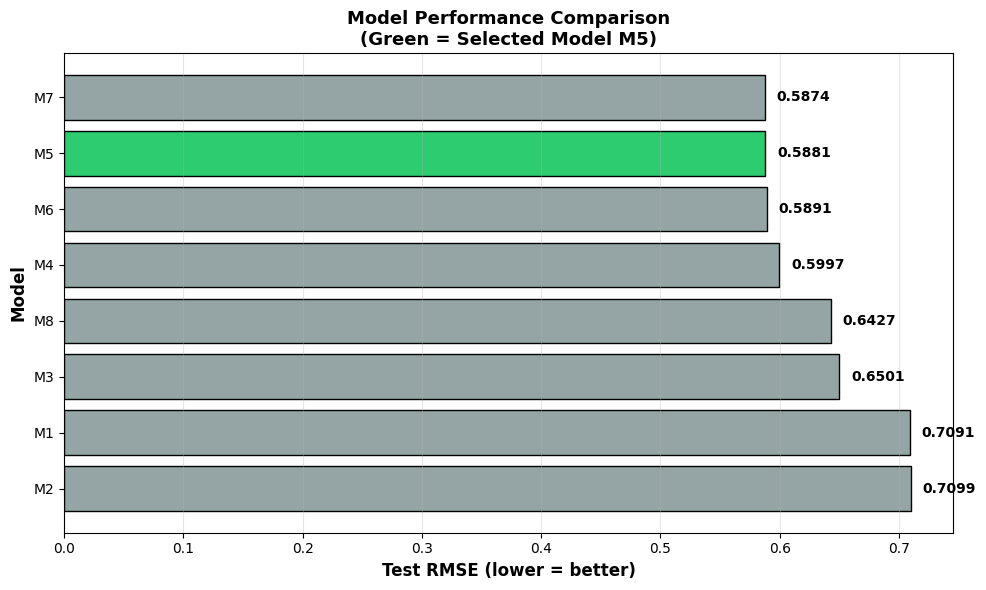

In [79]:
# Model Performance Bar Chart
#Simple bar chart comparing Test RMSE across all 8 models


fig, ax = plt.subplots(figsize=(10, 6))

# Sort by Test RMSE
perf_sorted = results_df.sort_values('Test_RMSE')

# Create bars
colors = ['#2ecc71' if m == 'M5' else '#95a5a6' for m in perf_sorted['Model']]
bars = ax.barh(perf_sorted['Model'], perf_sorted['Test_RMSE'], color=colors, edgecolor='black')

# Add values on bars
for bar, rmse in zip(bars, perf_sorted['Test_RMSE']):
    ax.text(rmse + 0.01, bar.get_y() + bar.get_height()/2,
            f'{rmse:.4f}', va='center', fontweight='bold', fontsize=10)

# Formatting
ax.set_xlabel('Test RMSE (lower = better)', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison\n(Green = Selected Model M5)',
             fontsize=13, fontweight='bold')
ax.invert_yaxis()  # Best model at top
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('phase6_simple_performance.png', dpi=300, bbox_inches='tight')
plt.show()

In [80]:
# quick check on final model
print("\nFinal results - M5")
print(f"test rmse: {test_rmse:.4f}")
print(f"r2: {final_mod.rsquared_adj:.2f}")
print("all vars sig at p<.01")

# standardized coefficients (actual importance)
print("\nStandardized coefs:")
for var, coef in zip(std_coefs.index, std_coefs.values):
    print(f"  {var}: {coef:.3f}")


Final results - M5
test rmse: 0.5881
r2: 0.76
all vars sig at p<.01

Standardized coefs:
  gdp_per_capita: 0.502
  social_support: 0.235
  freedom: 0.222
  healthy_life_expectancy: 0.153
  corruption: 0.123
  generosity: 0.091
